# 灵活的数据读取
前面的部分我们基本上已经把模型训练的流程讲完了，但是我们都是使用 pytorch 内置的数据集进行训练，接下来我们讲最后一个部分，如何使用自己的数据集进行模型的训练，这里会用到几个 pytorch 内置的，非常有用的函数，分别是 `torchvision.datasets.ImageFolder()`, `torch.utils.data.Dataset()` 和 `torch.utils.data.DataLoader()`，下面我们一次来讲一讲。

## ImageFolder
`torchvision.datasets.ImageFolder()` 是 torchvision 中内置的一个模块，专门处理分类问题，这是它的[文档](http://pytorch.org/docs/0.3.0/torchvision/datasets.html#imagefolder)，可以先看看文档，再看下面的解释和例子。

在 ImageFolder 的文档中已经说得很清楚了，将数据集按照着下面的格式放好就可以了

```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

比如这里是 2 分类，就分成两个文件夹，然后将同一类的图片放在同一个文件夹中，如果是 5 分类就分成五个文件夹就可以了，非常简单，同时 ImageFolder 还支持传入数据预处理的方式，下面我们举个例子。

In [2]:
from torchvision.datasets import ImageFolder

In [4]:
# 三个文件夹，每个文件夹一共有 3 张图片作为例子
folder_set = ImageFolder('./example_data/image/')

In [5]:
# 查看名称和类别下标的对应
folder_set.class_to_idx

{'class_1': 0, 'class_2': 1, 'class_3': 2}

In [7]:
# 得到所有的图片名字和标签
folder_set.imgs

[('./example_data/image/class_1/1.png', 0),
 ('./example_data/image/class_1/2.png', 0),
 ('./example_data/image/class_1/3.png', 0),
 ('./example_data/image/class_2/10.png', 1),
 ('./example_data/image/class_2/11.png', 1),
 ('./example_data/image/class_2/12.png', 1),
 ('./example_data/image/class_3/16.png', 2),
 ('./example_data/image/class_3/17.png', 2),
 ('./example_data/image/class_3/18.png', 2)]

In [11]:
# 取出其中一个数据
im, label = folder_set[0]

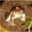

In [12]:
im

In [13]:
label

0

In [26]:
from torchvision import transforms as tfs

In [27]:
# 传入数据预处理方式
data_tf = tfs.ToTensor()

folder_set = ImageFolder('./example_data/image/', transform=data_tf)

im, label = folder_set[0]

In [28]:
im


(0 ,.,.) = 
  0.2314  0.1686  0.1961  ...   0.6196  0.5961  0.5804
  0.0627  0.0000  0.0706  ...   0.4824  0.4667  0.4784
  0.0980  0.0627  0.1922  ...   0.4627  0.4706  0.4275
           ...             ⋱             ...          
  0.8157  0.7882  0.7765  ...   0.6275  0.2196  0.2078
  0.7059  0.6784  0.7294  ...   0.7216  0.3804  0.3255
  0.6941  0.6588  0.7020  ...   0.8471  0.5922  0.4824

(1 ,.,.) = 
  0.2431  0.1804  0.1882  ...   0.5176  0.4902  0.4863
  0.0784  0.0000  0.0314  ...   0.3451  0.3255  0.3412
  0.0941  0.0275  0.1059  ...   0.3294  0.3294  0.2863
           ...             ⋱             ...          
  0.6667  0.6000  0.6314  ...   0.5216  0.1216  0.1333
  0.5451  0.4824  0.5647  ...   0.5804  0.2431  0.2078
  0.5647  0.5059  0.5569  ...   0.7216  0.4627  0.3608

(2 ,.,.) = 
  0.2471  0.1765  0.1686  ...   0.4235  0.4000  0.4039
  0.0784  0.0000  0.0000  ...   0.2157  0.1961  0.2235
  0.0824  0.0000  0.0314  ...   0.1961  0.1961  0.1647
           ...            

In [29]:
label

0

可以看到通过这种方式能够非常方便的访问每个数据点

## Dataset
前面讲了 ImageFolder 非常方便，但是如果我们得到的数据不是图片，而是 txt 文件，那 ImageFolder 就处理不了了，所以我们需要有一种更加灵活的方式来定义数据读入，这就需要用到 `torch.utils.data.Dataset()`。

其实 `torchvision.datasets.ImageFolder()` 只是 `torch.utils.data.Dataset()` 的一个子类，可以先看看 `Dataset` 的[文档](http://pytorch.org/docs/0.3.0/data.html?highlight=dataset#torch.utils.data.Dataset)

其实文档中已经说的很清楚了，如果我们希望定义自己的数据读入函数，我们只需要定义一个子类继承于 `Dataset`，然后重新定义 `__getitem__()` 和 `__len__()` 这两个函数就可以了，`__getitem__()` 表示按照下标取出其中一个数据，`__len__` 表示所有数据的总数，下面我们举个例子。

In [3]:
from torch.utils.data import Dataset

In [30]:
# 定义一个子类叫 custom_dataset，继承与 Dataset
class custom_dataset(Dataset):
    def __init__(self, txt_path, transform=None):
        self.transform = transform # 传入数据预处理
        with open(txt_path, 'r') as f:
            lines = f.readlines()
        
        self.img_list = [i.split()[0] for i in lines] # 得到所有的图像名字
        self.label_list = [i.split()[1] for i in lines] # 得到所有的 label 

    def __getitem__(self, idx): # 根据 idx 取出其中一个
        img = self.img_list[idx]
        label = self.label_list[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self): # 总数据的多少
        return len(self.label_list)

In [31]:
txt_dataset = custom_dataset('./example_data/train.txt') # 读入 txt 文件

In [32]:
# 取得其中一个数据
data, label = txt_dataset[0]
print(data)
print(label)

1009_2.png
YOU


In [33]:
# 再取一个
data2, label2 = txt_dataset[34]
print(data2)
print(label2)

1046_7.png
LIFE


所以通过这种方式我们也能够非常方便的定义一个数据读入，同时也能够方便的定义数据预处理

## DataLoader
有了上面两种方式，基本任何我们想要的数据读入都能够写出来，然后在训练的时候我们可以将数据一个一个读入模型，但是前面我们讲过，我们更希望能够一个 batch 的处理数据，所以 pytorch 提供了一个 python 的多线程迭代器，能够帮助我们一个 batch 的读入模型，同时使用多线程速度更快。

首先，可以看看 DataLoader 的[文档](http://pytorch.org/docs/0.3.0/data.html?highlight=dataset#torch.utils.data.DataLoader)

DataLoader 中有几个使用最多的参数，第一个是 `dataset`，就是我们前面定义的数据读入，可以使用 ImageFolder，可以使用自己定义的数据读入子类，第二个是 `batch_size`，这就是一批多少个数据，第三个是 `shuffle`，表示是否打乱数据，第四个是 `num_workers`，表示使用几个线程，默认使用主线程，第五个是 `drop_last`，表示是否扔掉最后无法构成一个批次的数据。

除了这些参数之外，还有一个参数叫 `collate_fn` 我们最后讲，首先我们举个例子

In [34]:
from torch.utils.data import DataLoader

In [35]:
train_data1 = DataLoader(folder_set, batch_size=2, shuffle=True) # 将 2 个数据作为一个 batch

In [36]:
for im, label in train_data1: # 访问迭代器
    print(label)


 1
 2
[torch.LongTensor of size 2]


 0
 1
[torch.LongTensor of size 2]


 0
 2
[torch.LongTensor of size 2]


 0
 2
[torch.LongTensor of size 2]


 1
[torch.LongTensor of size 1]



可以看到，通过训练我们可以访问到所有的数据，这些数据被分为了 5 个 batch，前面 4 个都有两个数据，最后一个 batch 只有一个数据，因为一共有 9 个数据，同时顺序也被打乱了

下面我们用自定义的数据读入举例子

In [41]:
train_data2 = DataLoader(txt_dataset, 8, True) # batch size 设置为 8

In [42]:
im, label = next(iter(train_data2)) # 使用这种方式访问迭代器中第一个 batch 的数据

In [43]:
im

('377_10.png',
 '178_1.png',
 '5008_4.png',
 '5050_5.png',
 '716_3.png',
 '415_8.png',
 '858_6.png',
 '5086_10.png')

In [44]:
label

('AUGUST',
 'OTKRIJTE',
 'ASTAIRE',
 'BOONMEE',
 'OF',
 'CAUTION',
 'PROPANE',
 'PECC')

最后我们讲一讲 `collate_fn` 这个函数，这个是在 DataLoader 中已经有默认定义了，感兴趣的同学可以去看看[源码](https://github.com/pytorch/pytorch/blob/master/torch/utils/data/dataloader.py#L100)

可能源码看着有点多，但是其作用就是如何一个 batch 的数据

为什么要讲这个东西了，比如现在有一个需求，希望能够将上面一个 batch 输出的 label 补成相同的长度，短的 label 用 0 填充，这其实是在机器翻译中的一个需求，这个时候我们就需要使用 `collate_fn` 来自定义我们 batch 的处理方式，下面直接举例子

In [85]:
def collate_fn(batch):
    batch.sort(key=lambda x: len(x[1]), reverse=True) # 将数据集按照 label 的长度从大到小排序
    img, label = zip(*batch) # 将数据和 label 配对取出
    # 填充
    pad_label = []
    lens = []
    max_len = len(label[0])
    for i in range(len(label)):
        temp_label = label[i]
        temp_label += '0' * (max_len - len(label[i]))
        pad_label.append(temp_label)
        lens.append(len(label[i]))
    pad_label 
    return img, pad_label, lens # 输出 label 的真实长度

使用我们自己定义 collate_fn 看看效果

In [91]:
train_data3 = DataLoader(txt_dataset, 8, True, collate_fn=collate_fn) # batch size 设置为 8

In [92]:
im, label, lens = next(iter(train_data3))

In [93]:
im

('5016_1.png',
 '2314_3.png',
 '731_9.png',
 '5019_4.png',
 '208_4.png',
 '5017_12.png',
 '5190_1.png',
 '855_12.png')

In [94]:
label

['LINDSAY',
 'ADDRESS',
 'MAIDEN0',
 'EINER00',
 'INDIA00',
 'GERE000',
 'JAWS000',
 'TD00000']

In [95]:
lens

[7, 7, 6, 5, 5, 4, 4, 2]

可以看到一个 batch 中所有的 label 都从长到短进行排列，同时短的 label 都被补长了，所以使用 collate_fn 能够非常方便的处理一个 batch 中的数据，一般情况下，没有特别的要求，使用 pytorch 中内置的 collate_fn 就可以满足要求了